# Age Estimation using VGG16 and Data Augmentation with Oversampling

In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.models import load_model
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.utils import shuffle

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

%matplotlib inline

from PIL import Image
import shutil

## Age estimation in age groups

### Set image size and variables 

In [2]:
IMAGE_SIZE = [224,224]
TRAIN_TEST_SPLIT = 0.3
BASE_DIR = '../input/utkface-new/UTKFace/'
NR_EPOCHS = 200


### Define methods map direct age to classes

In [3]:
def age_to_class( age ):
  age_class = None
  # 0 (0-20)
  if 0 <= age <= 20:
    age_class = 0
  # 1 (20-40)
  if 20 < age <= 40:
    age_class = 1
  # 2 (40-60)
  if 40 < age <= 60:
    age_class = 2
  # 3 (40-60)
  if 60 < age <= 80:
    age_class = 3
  # 3 (80+)
  if age > 80:
    age_class = 4
  return age_class

# map age classes for age gaps
age_dict = {0:'0-20', 1:'20-40',2:'40-60', 3:'60-80', 4:'80+'}

def decode_age_label(age_id):
  return age_dict[int(age_id)]

### Read input dataset

In [4]:
# read labels of image age, gender
image_paths = []
age_labels = []
gender_labels =[]
age_class = []

for filename in tqdm(os.listdir(BASE_DIR)):
  #read image path
  image_path = os.path.join(BASE_DIR, filename)
  #split filename to extract labels
  temp= filename.split('_')
  age = int(temp[0])
  gender = int(temp[1])
  image_paths.append(image_path)
  age_labels.append(age)
  gender_labels.append(gender)
  age_class.append(age_to_class(age))

# extract name of file 
names = []
for path in image_paths:
  temp = path.split('/')
  names.append(temp[4])

#convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['age_class'], df['name'] = image_paths, age_labels, gender_labels, age_class, names
df.head()
df

# get and print the number of images in dataframe
age_verbose = [age_dict[int(age)] for age in df['age_class']]

print(Counter(age_verbose))



  0%|          | 0/23708 [00:00<?, ?it/s]

Counter({'20-40': 12123, '0-20': 4877, '40-60': 4311, '60-80': 1857, '80+': 540})


### Shuffle and downsample dataset

In [5]:
# shuffle dataset for downsampling
df = shuffle(df)

In [6]:
# downsampling 
n = df['age_class'].value_counts().min()

df = df.groupby('age_class').head(n)
age_verbose_n = [age_dict[int(age)] for age in df['age_class']]


print(Counter(age_verbose_n))

Counter({'20-40': 540, '80+': 540, '0-20': 540, '40-60': 540, '60-80': 540})


In [7]:
# check dataframe
df 

,image,age,gender,age_class,name
5142,../input/utkface-new/UTKFace/36_0_0_2017011720...,36,0,1,36_0_0_20170117202645622.jpg.chip.jpg
11481,../input/utkface-new/UTKFace/87_1_0_2017011018...,87,1,4,87_1_0_20170110181045529.jpg.chip.jpg
23207,../input/utkface-new/UTKFace/40_0_3_2017010421...,40,0,1,40_0_3_20170104214526773.jpg.chip.jpg
6563,../input/utkface-new/UTKFace/20_1_0_2017010320...,20,1,0,20_1_0_20170103201716816.jpg.chip.jpg
13664,../input/utkface-new/UTKFace/1_1_1_20170109194...,1,1,0,1_1_1_20170109194611993.jpg.chip.jpg
...,...,...,...,...,...
5679,../input/utkface-new/UTKFace/85_1_0_2017011018...,85,1,4,85_1_0_20170110182428223.jpg.chip.jpg
22366,../input/utkface-new/UTKFace/84_0_0_2017011121...,84,0,4,84_0_0_20170111211153326.jpg.chip.jpg
20949,../input/utkface-new/UTKFace/95_1_0_2017011717...,95,1,4,95_1_0_20170117174948948.jpg.chip.jpg
17044,../input/utkface-new/UTKFace/81_1_0_2017012013...,81,1,4,81_1_0_20170120134927295.jpg.chip.jpg


### Data Augmentation

In [8]:
# create new folder for Data Augmentation
os.mkdir('./ds')

In [9]:
# copy all images of the downsampled df
image_list = df['image']
name_list = df['name']
source = '../input/utkface-new/'
#dest =  '../ds/'
dest = './ds/'

for key, val in df.iterrows():
    shutil.copyfile(val['image'], dest+val['name'])

print("finished copying images")

finished copying images


In [10]:
#zip for better download
#shutil.make_archive('new_ds', 'zip', dest)

In [11]:
# remove folder for new run
#shutil.rmtree('./ds/output/')

In [12]:
# use augmentor to increase the number of images
!pip install Augmentor
import Augmentor as aug

p = aug.Pipeline("./ds")
p.resize(1, 224, 224, resample_filter="ANTIALIAS")
p.flip_left_right(0.5)
p.rotate(0.8, 5, 10)
p.zoom(0.2, 0.9, 1.25)
p.shear(0.1, 0.01, 0.01)
p.sample(21000)

Initialised with 2700 image(s) found.
Output directory set to ./ds/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F5E5D822E50>: 100%|██████████| 21000/21000 [03:19<00:00, 105.52 Samples/s]


In [13]:
#zip for better download
shutil.make_archive('new_ds', 'zip', dest)

'/kaggle/working/new_ds.zip'

### Split Dataset into validation and test set  

In [14]:
val_data = df.sample(frac=0.8, random_state=25)
testing_data = df.drop(val_data.index)

 
print(f"No. of training examples: {val_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

#X = extract_features(training_data['image'])

No. of training examples: 2160
No. of testing examples: 540


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255,
                               preprocessing_function=preprocess_input,
                               rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])

val_datagen = ImageDataGenerator(rescale=1./255,
                                preprocessing_function=preprocess_input)


CLASS_MODE = 'raw'
BATCH_SIZE = 64
BASE_DIR = '../input/utkface-new/UTKFace'

train_generator = train_datagen.flow_from_dataframe(dataframe=df, 
                                                directory=BASE_DIR, 
                                                x_col='name', 
                                                y_col='age_class', 
                                                class_mode=CLASS_MODE,
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True, 
                                                target_size=IMAGE_SIZE)



val_generator = val_datagen.flow_from_dataframe(dataframe=val_data, 
                                              directory=BASE_DIR, 
                                              x_col='name', 
                                              y_col='age_class', 
                                              class_mode=CLASS_MODE, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False, 
                                              target_size=IMAGE_SIZE)

test_generator = val_datagen.flow_from_dataframe(dataframe=testing_data, 
                                              directory=BASE_DIR, 
                                              x_col='name', 
                                              y_col='age_class', 
                                              class_mode=CLASS_MODE, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False, 
                                              target_size=IMAGE_SIZE)


Found 2700 validated image filenames.
Found 2160 validated image filenames.
Found 540 validated image filenames.


In [16]:
from pathlib import Path
path = Path("./models")
path.mkdir(exist_ok=True)


MODEL_PATH = "./models/age_best_model.h5"


checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, 
                                                monitor='val_sparse_categorical_accuracy', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='max')

import datetime
log_dir = '../tblogs/age_model_' + datetime.datetime.now().strftime('%y-%m-%d_%H-%M')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)



2022-10-15 17:52:30.134012: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-15 17:52:30.134056: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-15 17:52:30.184918: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-10-15 17:52:30.216950: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-15 17:52:30.217106: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


### Build and load Model

In [17]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [18]:
# load VGG16 without the last 3 Dense layers, in order to train these new
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# check if input type is correct
vgg.inputs

2022-10-15 17:52:38.374680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 17:52:38.466181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 17:52:38.467045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 17:52:38.468081: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>]

In [19]:
# all layers before are locked
for layer in vgg.layers:
  layer.trainable = False


x = Flatten()(vgg.output)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
prediction = Dense(5, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# model.summary()
#tf.keras.utils.plot_model( model , to_file='architecture.png' )



# with tpu_strategy.scope():
#     x = Flatten()(vgg.output)
#     x = Dense(4096, activation='relu')(x)
#     x = Dense(4096, activation='relu')(x)
#     prediction = Dense(5, activation='softmax')(x)
#     model = Model(inputs=vgg.input, outputs=prediction)
    
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [20]:
from keras import callbacks

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

history = model.fit(train_generator,
                    epochs=NR_EPOCHS,
                    validation_data=val_generator,
                    callbacks = [tensorboard_callback, checkpoint]
                    )


2022-10-15 17:52:48.153609: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-10-15 17:52:50.494110: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/43 [..............................] - ETA: 8:41 - loss: 1.5972 - sparse_categorical_accuracy: 0.2969

2022-10-15 17:53:00.618689: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-15 17:53:00.618735: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/43 [>.............................] - ETA: 20s - loss: 16.7588 - sparse_categorical_accuracy: 0.2500

2022-10-15 17:53:01.094102: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-15 17:53:01.094878: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-10-15 17:53:01.236767: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 145 callback api events and 142 activity events. 
2022-10-15 17:53:01.245300: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-15 17:53:01.261350: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../tblogs/age_model_22-10-15_17-52/train/plugins/profile/2022_10_15_17_53_01

2022-10-15 17:53:01.267435: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ../tblogs/age_model_22-10-15_17-52/train/plugins/profile/2022_10_15_17_53_01/f4842c2a4057.trace.json.gz
2022-10-15 17:53:01.288275: I tensorflow/core/profiler/rpc/cli

43/43 [==============================] - 63s 1s/step - loss: 6.0431 - sparse_categorical_accuracy: 0.3819 - val_loss: 0.9773 - val_sparse_categorical_accuracy: 0.5935

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.59352, saving model to ./models/age_best_model.h5
Epoch 2/200
43/43 [==============================] - 48s 1s/step - loss: 1.0614 - sparse_categorical_accuracy: 0.5289 - val_loss: 0.8932 - val_sparse_categorical_accuracy: 0.6449

Epoch 00002: val_sparse_categorical_accuracy improved from 0.59352 to 0.64491, saving model to ./models/age_best_model.h5
Epoch 3/200
43/43 [==============================] - 49s 1s/step - loss: 1.0005 - sparse_categorical_accuracy: 0.5785 - val_loss: 0.8589 - val_sparse_categorical_accuracy: 0.6403

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.64491
Epoch 4/200
43/43 [==============================] - 47s 1s/step - loss: 0.9163 - sparse_categorical_accuracy: 0.6230 - val_loss: 0.8134 - val_sparse_categor

### Plot Training and Validation Loss

In [21]:
# print keys 
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

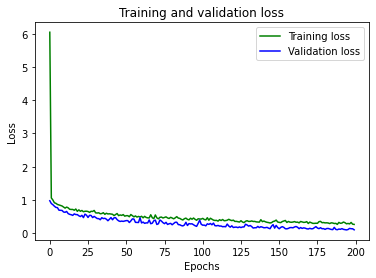

In [22]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(NR_EPOCHS)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

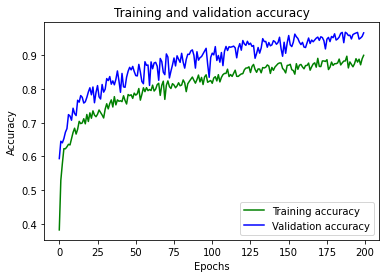

In [23]:
accuracy_train = history.history['sparse_categorical_accuracy']
accuracy_val = history.history['val_sparse_categorical_accuracy']
epochs = range(NR_EPOCHS)
plt.plot(epochs, accuracy_train, 'g', label='Training accuracy')
plt.plot(epochs, accuracy_val, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Load model and validate

In [24]:
model_age = load_model("./models/age_best_model.h5")
loss, acc = model_age.evaluate(test_generator)
print (loss, acc)

9/9 [==============================] - 5s 523ms/step - loss: 0.1183 - sparse_categorical_accuracy: 0.9574
0.1183130070567131 0.9574074149131775


### Show sample results

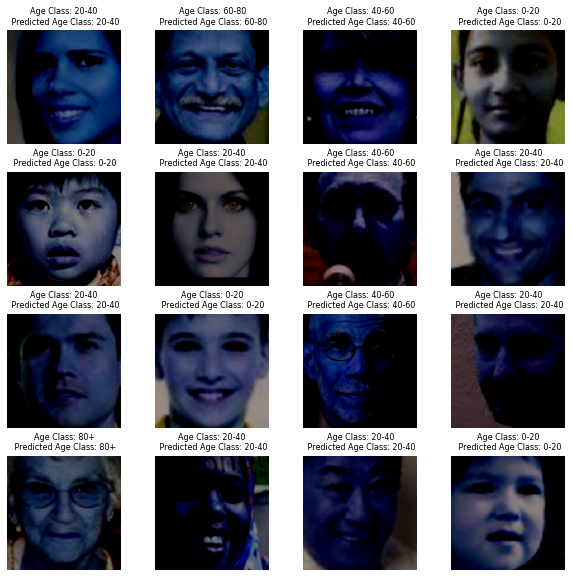

In [25]:
def show_faces(images, age=None, pred_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Age": [pred_age, age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.axis('off')
        #plt.xticks([])
        #plt.yticks([])
        #plt.grid(False)
        plt.imshow(images[i])
        
        if pred_age[i] is None:
            continue
           
            
        real_age = int(age[i])
        predicted_age = np.argmax(predicted[i])
                
                
        plt.title(f"Age Class: {age_dict[real_age]}\n Predicted Age Class: {age_dict[predicted_age]}", fontsize=8)
            
        plt.subplots_adjust(wspace=0.3)

sample_validation_images, sample_validation_labels = next(test_generator)
predicted = model_age.predict(sample_validation_images)
show_faces(sample_validation_images, age=sample_validation_labels, pred_age=predicted)

## Direct Age Estimation

In [26]:
NR_EPOCHS = 60

In [27]:
# reads image_path and returns decoded img 
def process_path(file_path, label):
    #read file path
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    #convert the values from 0-1
    img = tf.image.convert_image_dtype(img, tf.float32)
    # preprocess image for VGG16
    img = preprocess_input(img)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img, label

In [28]:
BASE = "./ds/output/"

In [29]:
# read labels of image age, gender
image_paths = []
age_labels = []
gender_labels =[]
age_class = []
print(len(os.listdir(BASE)))
for filename in tqdm(os.listdir(BASE)):
  image_path = os.path.join(BASE, filename)
  #split filename to get labels
  temp= filename.split('_')
  #print(temp)
  age = int(temp[2])
  gender = int(temp[3])
  image_paths.append(image_path)
  age_labels.append(age)
  gender_labels.append(gender)
  age_class.append(age_to_class(age))

names = []
for path in image_paths:
  temp = path.split('/')
  #print(temp[3])
  names.append(temp[3])

#convert to dataframe
aug_df = pd.DataFrame()
aug_df['image'], aug_df['age'], aug_df['gender'], aug_df['age_class'], aug_df['name'] = image_paths, age_labels, gender_labels, age_class, names
aug_df.head()
aug_df

age_verbose = [age_dict[int(age)] for age in aug_df['age_class']]

print(Counter(age_verbose))



21000


  0%|          | 0/21000 [00:00<?, ?it/s]

Counter({'0-20': 4303, '40-60': 4282, '60-80': 4199, '80+': 4154, '20-40': 4062})


### Split Dataset in Train, Validation and Test Dataset

In [30]:
training_data = aug_df
val_data = df.sample(frac=0.8, random_state=25)
testing_data = df.drop(val_data.index)

In [31]:
labels_train =  tf.keras.utils.to_categorical(training_data['age'], num_classes=117)
labels_val =  tf.keras.utils.to_categorical(val_data['age'], num_classes=117)
labels_test =  tf.keras.utils.to_categorical(testing_data['age'], num_classes=117) 

In [32]:
train_dataset = tf.data.Dataset.from_tensor_slices((training_data['image'],labels_train))
train_dataset = train_dataset.shuffle(len(training_data))
train_dataset = train_dataset.map(process_path, num_parallel_calls=4)
train_dataset = train_dataset.batch(64)


val_dataset = tf.data.Dataset.from_tensor_slices((val_data['image'],labels_val))
val_dataset = val_dataset.shuffle(len(val_data))
val_dataset = val_dataset.map(process_path, num_parallel_calls=4)
val_dataset = val_dataset.batch(64)

test_dataset = tf.data.Dataset.from_tensor_slices((testing_data['image'],labels_test))
test_dataset = test_dataset.shuffle(len(testing_data))
test_dataset = test_dataset.map(process_path, num_parallel_calls=4)
test_dataset = test_dataset.batch(64)

### Load and build model

In [33]:
model2 = VGG16(input_shape=IMAGE_SIZE + [3],weights='imagenet', include_top=False)

for layer in model2.layers:
    layer.trainable=False

In [34]:
x2 = Flatten()(model2.output)
x2 = Dense(4096, activation='relu')(x2)
x2 = Dense(4096, activation='relu')(x2)
prediction2 = Dense(117, activation='softmax')(x2)
model_direct = Model(inputs=model2.input, outputs=prediction2)
model_direct.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [35]:
model_direct.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [36]:

DIRECT_PATH = "./models/direct_age_aug_best_model.h5"


checkpoint = tf.keras.callbacks.ModelCheckpoint(DIRECT_PATH, 
                                                monitor='val_accuracy', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='max')

import datetime
log_dir = '../tblogs/direct_age_model_aug' + datetime.datetime.now().strftime('%y-%m-%d_%H-%M')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

log_dir

2022-10-15 20:50:43.798366: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-15 20:50:43.798428: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-15 20:50:43.995727: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-15 20:50:43.995917: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


'../tblogs/direct_age_model_aug22-10-15_20-50'

In [37]:
from keras import callbacks

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

history_direct = model_direct.fit(train_dataset,
                    epochs=NR_EPOCHS,
                    batch_size = 64,
                    validation_data=val_dataset,
                    callbacks = [tensorboard_callback, checkpoint]
                    )


Epoch 1/60
  1/329 [..............................] - ETA: 5:02 - loss: 6.5155 - accuracy: 0.0000e+00

2022-10-15 20:50:49.225116: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-15 20:50:49.225161: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/329 [..............................] - ETA: 1:55 - loss: 18.2290 - accuracy: 0.0156   

2022-10-15 20:50:49.667162: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-15 20:50:49.668004: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-10-15 20:50:49.800586: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 144 callback api events and 141 activity events. 
2022-10-15 20:50:49.806419: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-15 20:50:49.818695: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../tblogs/direct_age_model_aug22-10-15_20-50/train/plugins/profile/2022_10_15_20_50_49

2022-10-15 20:50:49.827334: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ../tblogs/direct_age_model_aug22-10-15_20-50/train/plugins/profile/2022_10_15_20_50_49/f4842c2a4057.trace.json.gz
2022-10-15 20:50:49.836134: I tensorflow/c

329/329 [==============================] - 59s 176ms/step - loss: 4.9912 - accuracy: 0.0530 - val_loss: 4.3937 - val_accuracy: 0.0616

Epoch 00001: val_accuracy improved from -inf to 0.06157, saving model to ./models/direct_age_aug_best_model.h5
Epoch 2/60
329/329 [==============================] - 54s 163ms/step - loss: 4.3757 - accuracy: 0.0568 - val_loss: 4.3677 - val_accuracy: 0.0616

Epoch 00002: val_accuracy did not improve from 0.06157
Epoch 3/60
329/329 [==============================] - 54s 164ms/step - loss: 4.3697 - accuracy: 0.0568 - val_loss: 4.3636 - val_accuracy: 0.0616

Epoch 00003: val_accuracy did not improve from 0.06157
Epoch 4/60
329/329 [==============================] - 54s 163ms/step - loss: 4.3646 - accuracy: 0.0568 - val_loss: 4.3603 - val_accuracy: 0.0616

Epoch 00004: val_accuracy did not improve from 0.06157
Epoch 5/60
329/329 [==============================] - 54s 164ms/step - loss: 4.3637 - accuracy: 0.0568 - val_loss: 4.3613 - val_accuracy: 0.0616

Epoch

### Plot Training and Validation Loss

In [38]:
history_direct.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

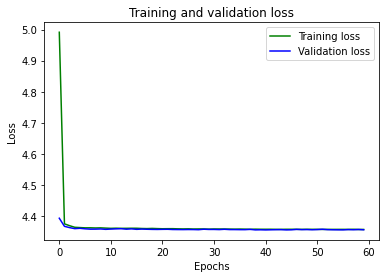

In [39]:
loss_train_direct = history_direct.history['loss']
loss_val_direct = history_direct.history['val_loss']
epochs = range(NR_EPOCHS)
plt.plot(epochs, loss_train_direct, 'g', label='Training loss')
plt.plot(epochs, loss_val_direct, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

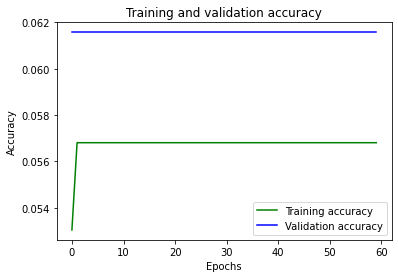

In [40]:
accuracy_direct = history_direct.history['accuracy']
accuracy_val_direct = history_direct.history['val_accuracy']
epochs = range(NR_EPOCHS)
plt.plot(epochs, accuracy_direct, 'g', label='Training accuracy')
plt.plot(epochs, accuracy_val_direct, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
from tensorflow.keras.models import load_model

model_age_direct = load_model("./models/direct_age_aug_best_model.h5")
loss, acc = model_age_direct.evaluate(test_dataset)
print(loss, acc)

9/9 [==============================] - 2s 165ms/step - loss: 4.4062 - accuracy: 0.0407
4.406243324279785 0.040740739554166794
